In [6]:
import pandas as pd
from kan.custom_processing import (plot_data_per_interval,
                                   plot_activation_and_spline_coefficients, get_masks)
import matplotlib.pyplot as plt
import os
import datetime
import json
import numpy as np

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures", "material_01")
os.makedirs(save_dir, exist_ok=True)

f_param = "P3HT_20251211_1539"
save_heading = os.path.join(save_dir, f_param + "_analysis")
d_opt = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', f_param + ".xlsx"), sheet_name='best_avg_by_params')
d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()

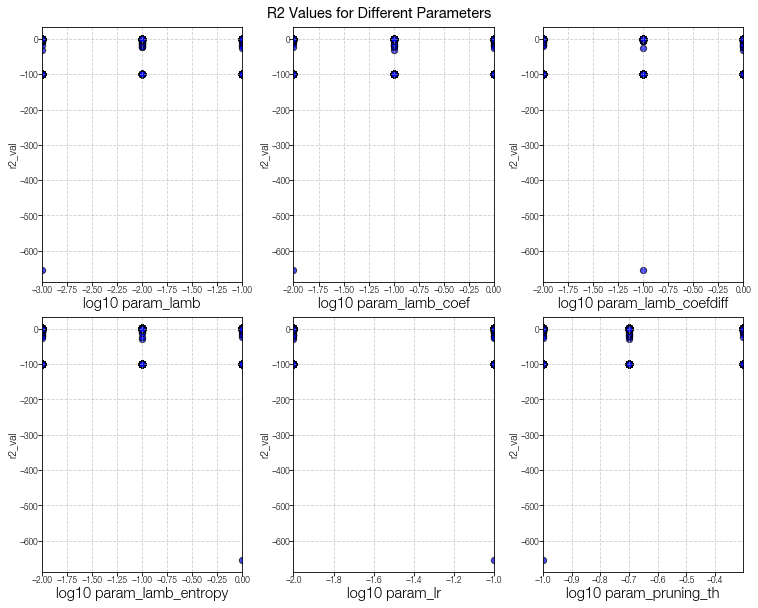

In [7]:
#TODO: Convert failed cases (-99) into bar graphs
f_tuning = f_param
df = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', f_tuning + ".xlsx"), sheet_name='results')

param_cols = [col for col in df.columns if 'param' in col and df[col].nunique() > 1]
num_params = len(param_cols)
cols = 3
rows = int(np.ceil(num_params / cols))

fig, axs = plt.subplots(rows, cols, figsize=(10, 4*rows), constrained_layout=True)
axs = np.atleast_1d(axs).flatten()

for i, param_name in enumerate(param_cols):
    ax = axs[i]

    if pd.api.types.is_numeric_dtype(df[param_name]):
    # if False:
        ax.scatter(np.log10(df[param_name]), df['r2_val'], alpha=0.7, c='blue', edgecolors='k')
        ax.set_xlabel("log10 " + param_name, fontsize=14)
    else:
        ax.scatter(df[param_name], df['r2_val'], alpha=0.7, c='blue', edgecolors='k')
        ax.set_xlabel(param_name, fontsize=14)
    # ax.set_ylim([0, 1.05])
    ax.set_ylabel('r2_val')
    ax.grid(True, linestyle='--', alpha=0.6)

# Hide any unused subplots if the grid is larger than the number of plots
for i in range(num_params, len(axs)):
    axs[i].axis('off')

plt.suptitle("R2 Values for Different Parameters", fontsize=14)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import torch

filepath = os.path.join(root_dir, "data", "P3HT.csv")
filedata = pd.read_csv(filepath)
name_X = filedata.columns[:-1].tolist()
name_y = filedata.columns[-1]
df_in = filedata[name_X]
df_out = filedata[[name_y]]
print(f"TARGET: {name_y}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out, rr=10)

removed_count = len(df_in) - len(df_in_final)
print(f"# of data after removing outliers: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)
print(f"Train set: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

TARGET: Conductivity (measured) (S/cm)
# of data after removing outliers: 206 개 (27 개 제거됨)
Train set: 131 (63.6%)
Validation set: 33 (16.0%)
Test set: 42 (20.4%)


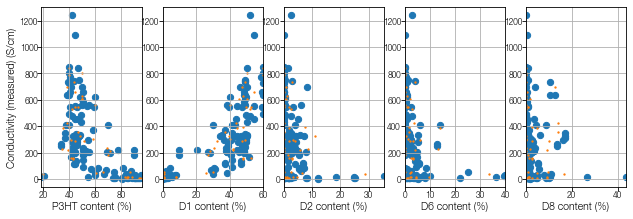

In [9]:
import matplotlib.pyplot as plt

num_input = X.shape[1]
fig, axs = plt.subplots(1, num_input, figsize=(10, 3))
for i in range(num_input):
    ax = axs[i]
    ax.scatter(X_train[:, i], y_train)
    ax.scatter(X_test[:, i], y_test, s=1.5)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()


| train_loss: 7.60e-02 | test_loss: 1.65e-01 | reg: 5.82e+00 | : 100%|█| 50/50 [00:05<00:00,  9.21it


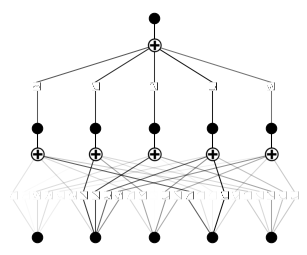

| train_loss: 6.96e-02 | test_loss: 4.01e-01 | reg: 6.61e+00 | : 100%|█| 50/50 [00:05<00:00,  9.09it


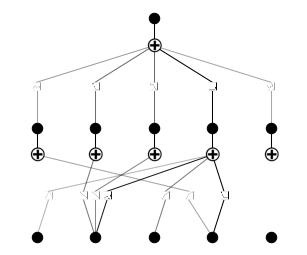

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]


ValueError: NaN in coefficients for act_fun layer 0

In [10]:
from kan.experiments.multkan_hparam_sweep import evaluate_params

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
print(res)
model.plot()
plt.show()

{'train': 0.639354589630768, 'test': 0.6874194575681217}


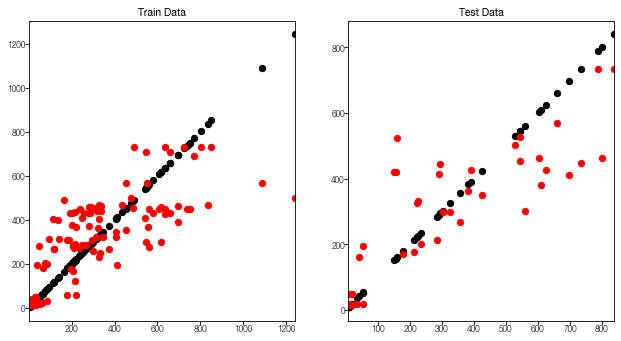

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

y_pred_norm_test = model.forward(x=dataset['test_input']).detach().cpu().numpy()
y_pred_norm_train = model.forward(x=dataset['train_input']).detach().cpu().numpy()

y_pred_test = scaler_y.inverse_transform(y_pred_norm_test)
y_pred_train = scaler_y.inverse_transform(y_pred_norm_train)

r2_score = {
    "train": r2_score(y_train, y_pred_train),
    "test": r2_score(y_test, y_pred_test),
}
print(r2_score)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax_train = ax[0]
ax_train.scatter(y_train, y_train, color='k')
ax_train.scatter(y_train, y_pred_train, color='r')
ax_train.set_title("Train Data")

ax_test = ax[1]
ax_test.scatter(y_test, y_test, color='k')
ax_test.scatter(y_test, y_pred_test, color='r')
ax_test.set_title("Test Data")

plt.show()
plt.show()